## Data Augmentation

* Augment the ASL dataset
* Use the augmented data to train an improved model

### Preparing the Data

In [1]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

### Model

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

### Data Augmentation

Before compiling the model, it's time to set up our data augmentation.
Keras comes with an image augmentation class called `ImageDataGenerator`. We recommend checking out the [documentation here](https://keras.io/api/preprocessing/image/#imagedatagenerator-class). It accepts a series of options for augmenting your data. For now, take a look at the options we've selected below, and then execute the cell to create an instance of the class:

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

### Batch Size

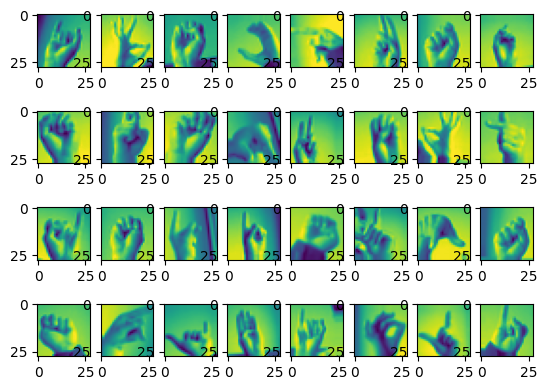

In [4]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

### Fitting the Data to the Generator

Next, the generator must be fit on the training dataset.

In [5]:
datagen.fit(x_train)

### Compiling the Model

In [6]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

### Training with Augmentation

In [7]:
model.fit(img_iter,
          epochs=10,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/10
857/857 [==============================] - 56s 64ms/step - loss: 1.1143 - accuracy: 0.6443 - val_loss: 0.3749 - val_accuracy: 0.8695
Epoch 2/10
857/857 [==============================] - 57s 67ms/step - loss: 0.3221 - accuracy: 0.8894 - val_loss: 0.3241 - val_accuracy: 0.9075
Epoch 3/10
857/857 [==============================] - 56s 65ms/step - loss: 0.1982 - accuracy: 0.9324 - val_loss: 0.1794 - val_accuracy: 0.9506
Epoch 4/10
857/857 [==============================] - 54s 62ms/step - loss: 0.1456 - accuracy: 0.9521 - val_loss: 0.2628 - val_accuracy: 0.9319
Epoch 5/10
857/857 [==============================] - 54s 62ms/step - loss: 0.1270 - accuracy: 0.9591 - val_loss: 0.1334 - val_accuracy: 0.9636
Epoch 6/10
857/857 [==============================] - 53s 62ms/step - loss: 0.1085 - accuracy: 0.9657 - val_loss: 0.0933 - val_accuracy: 0.9851
Epoch 7/10
857/857 [==============================] - 55s 65ms/step - loss: 0.1031 - accuracy: 0.9678 - val_loss: 0.1622 - val_accuracy:

### Saving the Model

In [8]:
model.save('asl_model.h5')